<a href="https://colab.research.google.com/github/eeshashetty/captionary-api/blob/main/blip_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install transformers
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
import gc
from tqdm.auto import tqdm
import os
from datasets import load_dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
train = load_dataset("eeshclusive/captionary-dataset", split = "train")
test = load_dataset("eeshclusive/captionary-dataset", split = "test")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/162 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/51 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/eeshclusive___parquet/eeshclusive--captionary-dataset-9a7e8b012e1ecc28/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("eeshclusive/captionary-BLIP")
model = BlipForConditionalGeneration.from_pretrained("eeshclusive/captionary-BLIP")

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
from torchvision import transforms, datasets

In [ ]:
train_dataset = ImageCaptioningDataset(train, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)

In [ ]:
test_dataset = ImageCaptioningDataset(test, processor)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=4)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

60

In [ ]:
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0): BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): BlipEncoderLayer(
          (self_attn): BlipAttention(
 

In [ ]:
def eval(model, dataloader):
  model.eval() # set model in evaluation mode
  vloss, vacc = 0, 0 # Monitoring loss and accuracy
  batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val')

  for idx, batch in enumerate(dataloader):

    ### Move data to device (ideally GPU)
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    # makes sure that there are no gradients computed as we are not training the model now
    with torch.inference_mode(): 
      ### Forward Propagation
      outputs  = model(input_ids=input_ids,
                  pixel_values=pixel_values,
                  labels=input_ids)
      ### Loss Calculation
      loss    = outputs.loss

    vloss   += loss.item()
    
    # Do you think we need loss.backward() and optimizer.step() here?

    batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (idx + 1))))
    batch_bar.update()

    ### Release memory
    del input_ids, pixel_values, outputs
    torch.cuda.empty_cache()

  batch_bar.close()
  vloss   /= len(dataloader)

  return vloss

In [ ]:
def train(model, dataloader, optimizer):
  model.train()
  tloss, tacc = 0, 0 # Monitoring loss and accuracy
  batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
      
    ### Initialize Gradients
    optimizer.zero_grad()
    
    with torch.autocast(device_type='cuda', dtype=torch.float16):
      ### Forward Propagation
      outputs  = model(input_ids=input_ids,
                  pixel_values=pixel_values,
                  labels=input_ids)
      
      ### Loss Calculation
      loss    = outputs.loss

    ### Backward Propagation
    scaler.scale(loss).backward()
    
    ### Gradient Descent
    scaler.step(optimizer)
    
    scaler.update()

    tloss   += loss.item()

    batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (idx + 1))))
    batch_bar.update()

    ### Release memory
    del input_ids, pixel_values, outputs
    torch.cuda.empty_cache()

  batch_bar.close()
  tloss   /= len(dataloader)
  return tloss

In [ ]:
!mkdir outputs

In [ ]:
EPOCHS = 20

In [ ]:
 # Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()

best_val_loss = -1

for epoch in range(EPOCHS):
 
    print("\nEpoch {}/{}".format(epoch+1, EPOCHS))

    train_loss   = train(model, train_dataloader, optimizer)
    val_loss       = eval(model, test_dataloader)

    print("\tTrain Loss {:.04f}".format(train_loss))
    print("\tVal Loss {:.04f}".format(val_loss))

    if val_loss < best_val_loss or best_val_loss == -1:
            best_val_loss = val_loss
            print(f"\nLowest validation loss: {best_val_loss:}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model.state_dict(), f"outputs/model_{epoch+1}_{val_loss}.pth")


Epoch 1/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 8.1256
	Val Loss 5.3221
\Lowest validation loss: 5.322124921358549

Saving best model for epoch: 1


Epoch 2/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 3.1276
	Val Loss 1.5943
\Lowest validation loss: 1.594318619141212

Saving best model for epoch: 2


Epoch 3/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.4304
	Val Loss 1.3788
\Lowest validation loss: 1.3787902410213764

Saving best model for epoch: 3


Epoch 4/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3708
	Val Loss 1.3662
\Lowest validation loss: 1.3662214187475352

Saving best model for epoch: 4


Epoch 5/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3636
	Val Loss 1.3631
\Lowest validation loss: 1.3631229308935313

Saving best model for epoch: 5


Epoch 6/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3608
	Val Loss 1.3605
\Lowest validation loss: 1.3604618310928345

Saving best model for epoch: 6


Epoch 7/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3595
	Val Loss 1.3596
\Lowest validation loss: 1.3595667068774884

Saving best model for epoch: 7


Epoch 8/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3589
	Val Loss 1.3591
\Lowest validation loss: 1.3591091816241925

Saving best model for epoch: 8


Epoch 9/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3585
	Val Loss 1.3589
\Lowest validation loss: 1.358868351349464

Saving best model for epoch: 9


Epoch 10/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3583
	Val Loss 1.3586
\Lowest validation loss: 1.3586496664927556

Saving best model for epoch: 10


Epoch 11/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3582
	Val Loss 1.3586
\Lowest validation loss: 1.358629978620089

Saving best model for epoch: 11


Epoch 12/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3581
	Val Loss 1.3585
\Lowest validation loss: 1.3584759327081533

Saving best model for epoch: 12


Epoch 13/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3580
	Val Loss 1.3585

Epoch 14/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3580
	Val Loss 1.3584
\Lowest validation loss: 1.3584431043038

Saving best model for epoch: 14


Epoch 15/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3580
	Val Loss 1.3584
\Lowest validation loss: 1.358420179440425

Saving best model for epoch: 15


Epoch 16/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3579
	Val Loss 1.3584
\Lowest validation loss: 1.358398098212022

Saving best model for epoch: 16


Epoch 17/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3579
	Val Loss 1.3584
\Lowest validation loss: 1.3583875711147602

Saving best model for epoch: 17


Epoch 18/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3579
	Val Loss 1.3584
\Lowest validation loss: 1.3583820324677687

Saving best model for epoch: 18


Epoch 19/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3579
	Val Loss 1.3584

Epoch 20/20


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

	Train Loss 1.3579
	Val Loss 1.3584


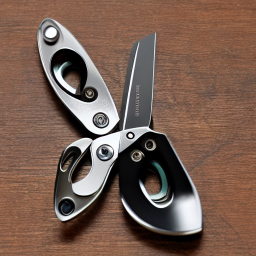

In [ ]:
# load image
example = test[2]
image = example["image"]
image

In [ ]:
from PIL import Image
import requests

In [ ]:
# url = "https://upcdn.io/FW25b4F/raw/uploads/scribble-diffusion/1.0.0/2023-02-27/scribble_input_6cWWY7uz.png"
url_pic = "https://replicate.delivery/pbxt/NFSsdG1sVxqUOJrduzNnh8jmON5hKcZBjHYze1qTXNe52siQA/output_1.png"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


a bear


In [ ]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs)

AttributeError: ignored

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import huggingface_hub
huggingface_hub.login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.push_to_hub("eeshclusive/captionary-BLIP")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eeshclusive/captionary-BLIP/commit/22e330c768cbbb47202ff54ba37616bbe2157f22', commit_message='Upload BlipForConditionalGeneration', commit_description='', oid='22e330c768cbbb47202ff54ba37616bbe2157f22', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
int(1 == 1)

1